In [83]:
import numpy as np
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada2.model import BinaryClassifier, Sequential, Dense, Dropout, adagrad
from ada2.data import read_dataset, split_dataset
import pandas as pd
from functools import partial
from tensorflow.keras import initializers
from matplotlib import pyplot as plt

In [3]:
source_path = "../processed_data/xtohh"
signal = "Xtohh2000"
bg = "Xtohh_background"
seed = 420

In [4]:
#read xtohh dataset
df = read_dataset(source_path, signal, bg, "SR", 2)
sets = split_dataset(df, 0.6, 0.2, 0.2, seed)

In [20]:
neg, pos = np.bincount(df['label'])
print(neg,pos)

246 8560


In [5]:
df

,EventWeight,label,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt
0,0.001020,1,885.55927,0.104927,-2.448576,127604.30,623.22710,-0.731510,0.656939,85368.720,3.105514,3.216185,-0.192894,237.887240,1631.67020,263.697630
1,0.001117,1,855.69904,0.313113,-1.859287,122862.90,449.37933,-0.306591,0.920655,55754.656,2.779941,2.848176,-0.019178,485.033330,1293.40280,463.512360
2,0.000925,1,552.47845,-0.702952,-2.549875,109091.67,631.70496,1.020756,0.610602,76213.550,3.122708,3.566858,-0.742126,104.559220,1659.84830,80.008150
3,0.001158,1,525.10590,-0.941433,-1.130162,82382.28,416.48105,0.103909,1.981465,58332.793,3.111627,3.282524,-0.130256,166.607220,1075.30920,109.524925
4,0.001120,1,916.44147,-0.683193,1.804695,115936.01,677.16440,-0.495132,-1.274429,94135.960,3.079124,3.084862,0.416606,167.350300,1595.76110,244.283460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8801,0.006433,0,402.06714,0.109710,-1.277847,68576.34,486.71262,-0.060529,1.469456,120999.410,2.747302,2.752572,-0.883233,84.210686,891.92240,192.862270
8802,0.004849,0,542.29900,1.579771,-2.624035,84161.26,411.07132,1.205967,0.438185,56194.777,3.062220,3.084951,-0.216563,59.169407,970.41110,136.471160
8803,0.004849,0,548.63104,-0.033452,2.621298,79095.04,416.03915,0.336025,-0.553298,70408.830,3.108589,3.130470,-0.352454,34.371227,983.20233,133.526060
8804,0.007816,0,683.98340,-0.029910,-0.760806,110728.80,609.47140,0.094448,2.401307,148632.220,3.121072,3.123549,0.351719,55.616740,1320.47700,75.680750


In [6]:
n_input = sets["x"]["train"].shape[1]
print(n_input)

14


In [7]:
from tensorflow import convert_to_tensor, constant, clip_by_value, math
from tensorflow.keras.backend import mean, epsilon
from tensorflow import nn

def get_focal_loss(target, output, alpha, gamma):
    epsilon_ = constant(epsilon(), output.dtype.base_dtype)
    output = clip_by_value(output, epsilon_, 1. - epsilon_)

    bce = target * math.log(output + epsilon()) * (1 - output)**gamma
    bce += (1 - target) * math.log(1 - output + epsilon()) * (output)**gamma
    return -alpha * bce

def focal_loss(alpha, gamma):

    def focal_loss_aux(y_true, y_pred):
        return mean(get_focal_loss(y_true, y_pred, alpha, gamma), axis=-1)
        
    return focal_loss_aux





In [23]:
output_bias = np.log([pos/neg])
output_bias = initializers.Constant(output_bias)

In [86]:
model = Sequential()
model.add(Dense(32, input_dim = n_input, kernel_initializer='uniform',activation='softplus'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, kernel_initializer='he_uniform', activation='softplus'))
model.add(Dropout(rate=0.2))
model.add(Dense(128, kernel_initializer='he_uniform', activation='softplus'))
model.add(Dropout(rate=0.2))
#model.add(Dense(256, kernel_initializer='he_uniform', activation='softplus'))
#model.add(Dropout(rate=0.2))
#model.add(Dense(128, kernel_initializer='he_uniform', activation='softplus'))
#model.add(Dropout(rate=0.2))
#model.add(Dense(64, kernel_initializer='he_uniform', activation='softplus'))
#model.add(Dropout(rate=0.2))
model.add(Dense(32, kernel_initializer='he_uniform', activation='softplus'))
model.add(Dropout(rate=0.2))
model.add(Dense(1, kernel_initializer='he_uniform', activation='sigmoid',bias_initializer=output_bias))
model.compile(optimizer=adagrad(lr=0.05), loss = focal_loss(1,2))
#model.compile(optimizer=optmizers.RMSProp(lr=0.01), loss = focal_loss(1,2))



In [87]:
history  =model.fit(sets["x"]["train"], sets["y"]["train"],batch_size = 200, 
                    epochs = 20, class_weight=sets["w"]["train"], validation_split=0.2)

Train on 4226 samples, validate on 1057 samples
Epoch 1/20
4226/4226 [==============================] - 2s 566us/step - loss: 1.4597 - val_loss: 0.0411
Epoch 2/20
4226/4226 [==============================] - 0s 116us/step - loss: 0.0414 - val_loss: 0.0281
Epoch 3/20
4226/4226 [==============================] - 1s 136us/step - loss: 0.0345 - val_loss: 0.0209
Epoch 4/20
4226/4226 [==============================] - 0s 110us/step - loss: 0.0349 - val_loss: 0.0239
Epoch 5/20
4226/4226 [==============================] - 0s 70us/step - loss: 0.0299 - val_loss: 0.0186
Epoch 6/20
4226/4226 [==============================] - 0s 77us/step - loss: 0.0277 - val_loss: 0.0180
Epoch 7/20
4226/4226 [==============================] - 0s 80us/step - loss: 0.0257 - val_loss: 0.0150
Epoch 8/20
4226/4226 [==============================] - 0s 109us/step - loss: 0.0282 - val_loss: 0.0145
Epoch 9/20
4226/4226 [==============================] - 0s 84us/step - loss: 0.0235 - val_loss: 0.0154
Epoch 10/20
4226/422

In [66]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

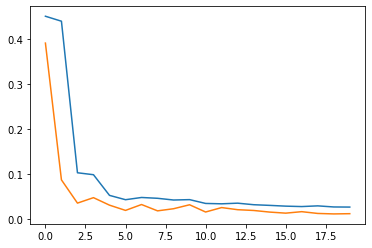

In [67]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

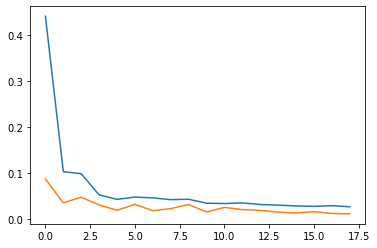

In [68]:
plt.figure()
plt.plot(history.history["loss"][1:-1])
plt.plot(history.history["val_loss"][1:-1])
plt.show()

In [69]:
x_train = sets["x"]["train"]
y_train = sets["y"]["train"]
w_train = sets["w"]["train"]
x_val = sets["x"]["val"]
y_val = sets["y"]["val"]
w_val = sets["w"]["val"]

x_test = sets["x"]["test"]
y_test = sets["y"]["test"]
w_test = sets["w"]["test"]

In [70]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [71]:
th = 0.5
y_pred_train = model.predict(x_train)
y_pred_train = (y_pred_train > th).astype(int)

acc= accuracy_score(y_train, y_pred_train)
prec = precision_score(y_train, y_pred_train)
rec = recall_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)
print(acc, prec, rec, f1)

0.9829642248722317 0.9836632711896982 0.9990240093695101 0.9912841371295759


In [72]:
y_pred_test = model.predict(x_test)
y_pred_test = (y_pred_test> th).astype(int)

acc= accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
print(acc, prec, rec, f1)

0.9824063564131669 0.9844738355376653 0.9976689976689976 0.991027496382055


In [73]:
y_pred_val = model.predict(x_val)
y_pred_val = (y_pred_val > th).astype(int)



acc= accuracy_score(y_val, y_pred_val)
prec = precision_score(y_val, y_pred_val)
rec = recall_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)
print(acc, prec, rec, f1)

0.9880749574105622 0.9885057471264368 0.999418942475305 0.9939323894828084


In [74]:
for key in sets["y"].keys():
    print("-------", key)
    print(sets["y"][key].sum(),sets["y"][key].shape,sets["y"][key].shape[0]- sets["y"][key].sum())
    pred = model.predict(sets["x"][key])
    pred = (pred > th).astype(int)


    cm1= confusion_matrix(sets["y"][key], pred)
    acc = accuracy_score(sets["y"][key], pred)
    prec = precision_score(sets["y"][key], pred)
    rec = recall_score(sets["y"][key], pred)
    print(cm1)
    print(acc, prec, rec)

------- train
5123 (5283, 1) 160
[[  75   85]
 [   5 5118]]
0.9829642248722317 0.9836632711896982 0.9990240093695101
------- val
1721 (1761, 1) 40
[[  20   20]
 [   1 1720]]
0.9880749574105622 0.9885057471264368 0.999418942475305
------- test
1716 (1762, 1) 46
[[  19   27]
 [   4 1712]]
0.9824063564131669 0.9844738355376653 0.9976689976689976
